In [1]:
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error

import lightgbm as lgb; print('lightgbm version :', lgb.__version__)
from lightgbm.callback import early_stopping
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

sns.set(rc = {"figure.figsize" : (15,8)})
sns.set_style('white')
plt.rc("axes", unicode_minus=False) # 음수값 깨지는 폰트 설정
plt.rc('font', family='NanumBarunGothic')

RANDOM_SEED = 42

lightgbm version : 4.3.0


* 데이터 샘플
    * DO (Dissolved Oxygen, 용존 산소, ㎎/L)
    * BOD (Biochemical Oxygen Demand, 생물학적 산소 요구량, ㎎/L)
    * COD (Chemical Oxygen Demand, 화학적 산소 요구량, ㎎/L)
    * SS (Suspended Solids, 부유 고형물, ㎎/L)
    * TN (Total Nitrogen, 총 질소, ㎎/L)
    * TP (Total Phosphorus, 총 인, ㎎/L)
    * TOC (Total Organic Carbon, 총 유기 탄소, ㎎/L)

In [2]:
wq_data = pd.read_excel("수질데이터.xlsx", skiprows=1, header=0)
display(wq_data.head())

,측정소명,년,월,수온(℃),DO(㎎/L),BOD(㎎/L),COD(㎎/L),SS(㎎/L),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),총대장균군수(총대장균군수/100ml),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),클로로필 a(㎎/㎥),분원성대장균군수,유량(㎥/s)
0,이포,2021,1,3.6,13.6,0.8,3.1,2.2,3.097,0.027,1.8,8.2,320,205,3.076,0.130,2.730,0.014,0.007,2.3,41,106.568
1,이포,2021,2,4.4,13.9,1.1,3.8,3.6,3.036,0.028,2.1,8.5,311,34,2.943,0.107,2.669,0.010,0.002,11.0,12,87.608
2,이포,2021,3,9.7,12.8,2.9,5.2,16.7,2.993,0.072,2.9,8.7,296,4996,2.793,0.097,2.444,0.017,0.007,34.1,1350,146.800
3,이포,2021,4,14.0,12.7,2.2,4.8,11.0,2.611,0.046,2.9,8.9,273,1428,2.535,0.031,2.216,0.012,0.004,30.2,643,156.350
4,이포,2021,5,16.7,9.6,1.8,5.2,27.6,2.891,0.122,3.4,8.1,285,17980,2.699,0.188,2.196,0.048,0.038,18.7,7900,201.480


* 측정소명 별 데이터 개수 (12개/1년, 총 3년)

In [3]:
print("측정소 수 :", len(wq_data['측정소명'].unique()))
print("총 데이터 수 :", len(wq_data))
wq_data['측정소명'].value_counts()

측정소 수 : 17
총 데이터 수 : 612


측정소명
이포       36
오산천4     36
진위천5     36
황구지천6    36
황구지천5    36
황구지천4    36
황구지천1    36
오산천6     36
오산천2     36
묵현천      36
왕숙천6     36
팔당       36
신천5      36
공릉천5     36
행주       36
탄천5      36
진위천6     36
Name: count, dtype: int64

* 월 피쳐 변경

In [4]:
wq_data['월_cos'] = np.cos(2 * np.pi * wq_data['월'] / 12)
wq_data['월_sin'] = np.sin(2 * np.pi * wq_data['월'] / 12)

* 총 피쳐명

In [5]:
feature_list = wq_data.columns.tolist()
feature_list

['측정소명',
 '년',
 '월',
 '수온(℃)',
 'DO(㎎/L)',
 'BOD(㎎/L)',
 'COD(㎎/L)',
 'SS(㎎/L)',
 'TN(㎎/L)',
 'TP(㎎/L)',
 'TOC(㎎/L)',
 '수소이온농도',
 '전기전도도(μS/㎝)',
 '총대장균군수(총대장균군수/100ml)',
 '용존총질소(㎎/L)',
 '암모니아성 질소(㎎/L)',
 '질산성 질소(㎎/L)',
 '용존총인(㎎/L)',
 '인산염인(㎎/L)',
 '클로로필 a(㎎/㎥)',
 '분원성대장균군수',
 '유량(㎥/s)',
 '월_cos',
 '월_sin']

* feature명 영어로 변환

In [6]:
# # 한글 feature 명과 영어 feature 명 매핑
# feature_name_mapping = {
#     '측정소명': 'Station_Name',
#     '년': 'Year',
#     '월': 'Month',
#     '수온(℃)': 'Water_Temperature',
#     'DO(㎎/L)': 'DO',
#     'BOD(㎎/L)': 'BOD',
#     'COD(㎎/L)': 'COD',
#     'SS(㎎/L)': 'SS',
#     'TN(㎎/L)': 'TN',
#     'TP(㎎/L)': 'TP',
#     'TOC(㎎/L)': 'TOC',
#     '수소이온농도': 'pH',
#     '전기전도도(μS/㎝)': 'Electrical_Conductivity',
#     '총대장균군수(총대장균군수/100ml)': 'Total_Coliforms',
#     '용존총질소(㎎/L)': 'Total_Dissolved_Nitrogen',
#     '암모니아성 질소(㎎/L)': 'Ammonia_Nitrogen',
#     '질산성 질소(㎎/L)': 'Nitrate_Nitrogen',
#     '용존총인(㎎/L)': 'Total_Dissolved_Phosphorus',
#     '인산염인(㎎/L)': 'Phosphate_Phosphorus',
#     '클로로필 a(㎎/㎥)': 'Chlorophyll_a',
#     '분원성대장균군수': 'Fecal_Coliforms',
#     '유량(㎥/s)': 'Flow_Rate',
#     '월_cos': 'Month_cos',
#     '월_sin': 'Month_sin'
# }

# # 데이터프레임의 feature 이름 변경
# wq_data = wq_data.rename(columns=feature_name_mapping)
# wq_data.head()

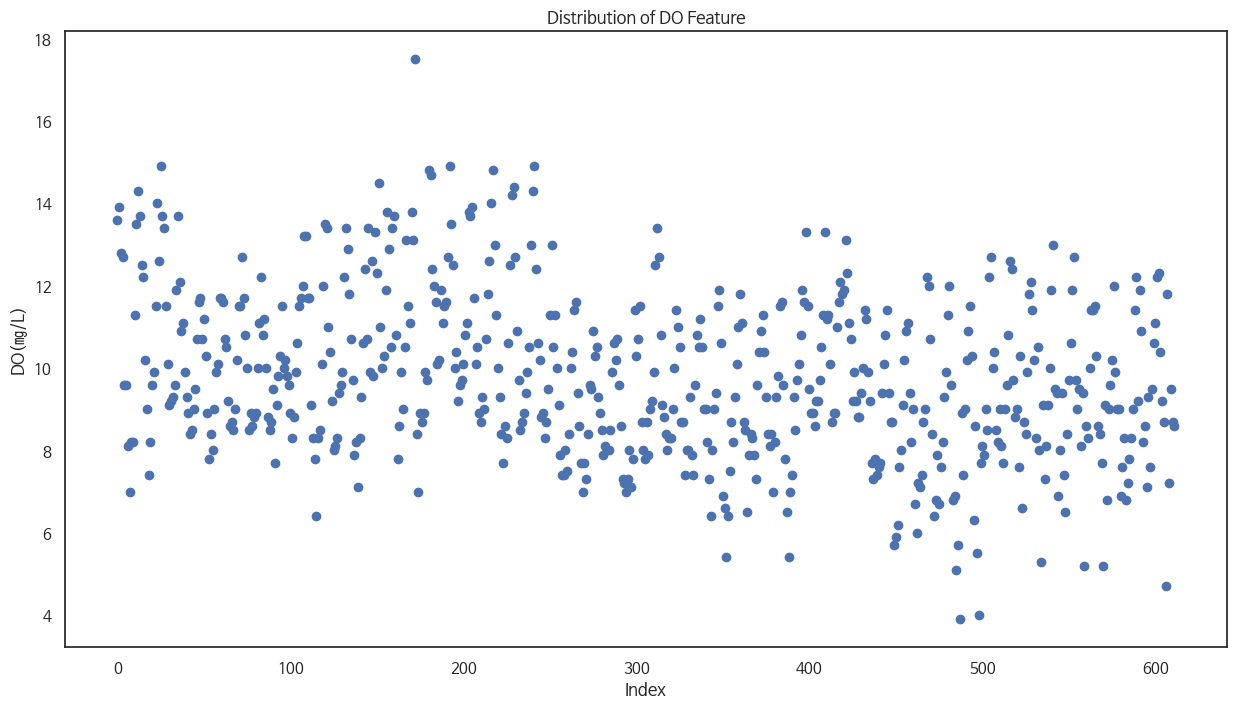

In [8]:
plt.scatter(range(len(wq_data)), wq_data['DO(㎎/L)'])
plt.xlabel('Index')
plt.ylabel('DO(㎎/L)')
plt.title('Distribution of DO Feature')
plt.show()

* 중요한 종속변수 찾기

In [13]:
feature_X = [
    '월_cos',
    '월_sin',
    '수온(℃)',
    'BOD(㎎/L)',
    'COD(㎎/L)',
    'SS(㎎/L)',
    'TN(㎎/L)',
    'TP(㎎/L)',
    'TOC(㎎/L)',
    '수소이온농도',
    '전기전도도(μS/㎝)',
    '총대장균군수(총대장균군수/100ml)',
    '용존총질소(㎎/L)',
    '암모니아성 질소(㎎/L)',
    '질산성 질소(㎎/L)',
    '용존총인(㎎/L)',
    '인산염인(㎎/L)',
    '클로로필 a(㎎/㎥)',
    '분원성대장균군수',
    '유량(㎥/s)',
]

wq_X = wq_data[feature_X]

feature_Y = ['DO(㎎/L)']
wq_Y = wq_data[feature_Y]
print("wq_X.shape :", wq_X.shape)
display(wq_X.head())
print("wq_Y.shape :", wq_Y.shape)
display(wq_Y.head())

## 인코딩
number_cols = wq_X.select_dtypes(include=['float64','int64']).columns
for col in number_cols:
    ss = StandardScaler()
    # .loc를 사용하여 명확하게 특정 열에 대한 변경을 적용합니다.
    wq_X.loc[:, col] = ss.fit_transform(wq_X[[col]])
    
print("after ss :")
display(wq_X.head())
display(wq_Y.head())

wq_X.shape : (612, 20)


,월_cos,월_sin,수온(℃),BOD(㎎/L),COD(㎎/L),SS(㎎/L),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),총대장균군수(총대장균군수/100ml),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),클로로필 a(㎎/㎥),분원성대장균군수,유량(㎥/s)
0,8.660254e-01,0.500000,3.6,0.8,3.1,2.2,3.097,0.027,1.8,8.2,320,205,3.076,0.130,2.730,0.014,0.007,2.3,41,106.568
1,5.000000e-01,0.866025,4.4,1.1,3.8,3.6,3.036,0.028,2.1,8.5,311,34,2.943,0.107,2.669,0.010,0.002,11.0,12,87.608
2,6.123234e-17,1.000000,9.7,2.9,5.2,16.7,2.993,0.072,2.9,8.7,296,4996,2.793,0.097,2.444,0.017,0.007,34.1,1350,146.800
3,-5.000000e-01,0.866025,14.0,2.2,4.8,11.0,2.611,0.046,2.9,8.9,273,1428,2.535,0.031,2.216,0.012,0.004,30.2,643,156.350
4,-8.660254e-01,0.500000,16.7,1.8,5.2,27.6,2.891,0.122,3.4,8.1,285,17980,2.699,0.188,2.196,0.048,0.038,18.7,7900,201.480


wq_Y.shape : (612, 1)


,DO(㎎/L)
0,13.6
1,13.9
2,12.8
3,12.7
4,9.6


after ss :


,월_cos,월_sin,수온(℃),BOD(㎎/L),COD(㎎/L),SS(㎎/L),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),총대장균군수(총대장균군수/100ml),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),클로로필 a(㎎/㎥),분원성대장균군수,유량(㎥/s)
0,1.224745e+00,0.707107,-1.906261,-0.814047,-1.090908,-0.613023,-1.296662,-1.109599,-1.656968,1.223108,-0.897187,-0.168047,-1.235045,-0.668083,-0.898928,-0.992832,-0.921867,-0.508806,-0.158347,0.210216
1,7.071068e-01,1.224745,-1.798168,-0.713644,-0.897934,-0.504520,-1.320291,-1.101487,-1.481686,2.044778,-0.916430,-0.168305,-1.288311,-0.684152,-0.937349,-1.042729,-0.994667,-0.257595,-0.158424,0.113231
2,1.532989e-16,1.414214,-1.082053,-0.111230,-0.511985,0.510751,-1.336947,-0.744562,-1.014268,2.592558,-0.948500,-0.160812,-1.348386,-0.691139,-1.079064,-0.955410,-0.921867,0.409414,-0.154890,0.416013
3,-7.071068e-01,1.224745,-0.501055,-0.345502,-0.622256,0.068992,-1.484920,-0.955472,-1.014268,3.140339,-0.997675,-0.166200,-1.451716,-0.737252,-1.222670,-1.017781,-0.965547,0.296802,-0.156757,0.464864
4,-1.224745e+00,0.707107,-0.136242,-0.479372,-0.511985,1.355518,-1.376458,-0.338965,-0.722131,0.949217,-0.972019,-0.141205,-1.386033,-0.627559,-1.235266,-0.568713,-0.470509,-0.035258,-0.137589,0.695716


,DO(㎎/L)
0,13.6
1,13.9
2,12.8
3,12.7
4,9.6


In [14]:
## 파라미터 설정
lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': 42,
    'metric': ['mse'],
    'verbose': -1,
}

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

## Feature Importance 추출
def get_FI_lgb(X_train, y_train, lgb_param):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    oof = np.zeros(len(X_train))
    feature_importance_df = pd.DataFrame()
    params = {'verbose': -1}
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx], params=params)
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data], callbacks=[early_stopping(stopping_rounds=200, verbose=True)])
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        cv_fold_score = mse(y_train.iloc[val_idx], oof[val_idx])
        print("cv_fold_score :", cv_fold_score)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = mse(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    return feature_importance_df, y_train, oof

feature_importance_df, y_train, oof = get_FI_lgb(wq_X, wq_Y, lgb_param)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	training's l2: 0.448065	valid_1's l2: 0.758591
cv_fold_score : 0.7585906591454756
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[641]	training's l2: 0.01225	valid_1's l2: 0.665629
cv_fold_score : 0.6656286510516739
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[330]	training's l2: 0.0648261	valid_1's l2: 0.586432
cv_fold_score : 0.5864315344034181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[184]	training's l2: 0.147956	valid_1's l2: 0.591961
cv_fold_score : 0.5919612467696808
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[923]	training's l2: 0.00991849	valid_1's l2: 0.586322
cv_fold_score : 0.5863216684386511
CV-Score: 0.638030


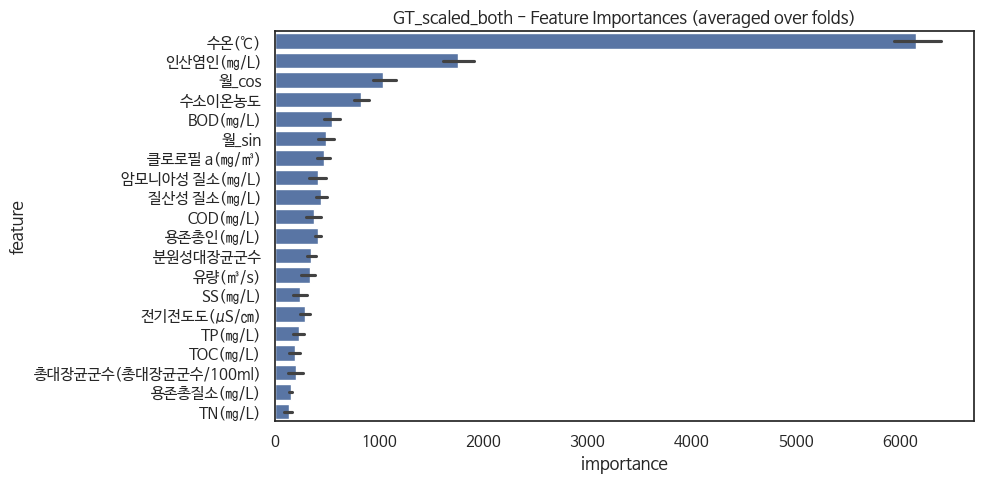

In [15]:
## Feature Importance 확인
plt.figure(figsize=(10,5))

cols = (feature_importance_df[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False)[:20].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
plt.title('GT_scaled_both - Feature Importances (averaged over folds)')
plt.tight_layout()